In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import tools
from mpl_toolkits.mplot3d import Axes3D
import pickle
%matplotlib notebook

### Kamere

In [2]:
N_cams = 5
r = 500
max_angle = np.pi/4
axis = np.array([0, 1, 0], dtype=float)
angles = -np.linspace(0, max_angle, N_cams)
Cs = np.column_stack((np.cos(-angles-np.pi/2), np.zeros(N_cams), 1+np.sin(-angles-np.pi/2))) * r

In [3]:
Rs = [cv2.Rodrigues(angle*axis)[0].T for angle in angles]
ts = np.array([-np.dot(Rs[i], Cs[i]) for i in range(N_cams)])
Ps = [np.column_stack((Rs[i], ts[i])) for i in range(N_cams)]

In [4]:
Xs, Ys, Zs = np.array([tools.pos_from_P(P)[:-1, -1] for P in Ps]).T
Xd, Yd, Zd = np.column_stack([R[2] for R in Rs])

In [5]:
R = np.linspace(0, 1., N_cams)
G = np.linspace(0.5, 1., N_cams)
B = R[::-1]
c_colors = np.column_stack((R, G, B))

<IPython.core.display.Javascript object>


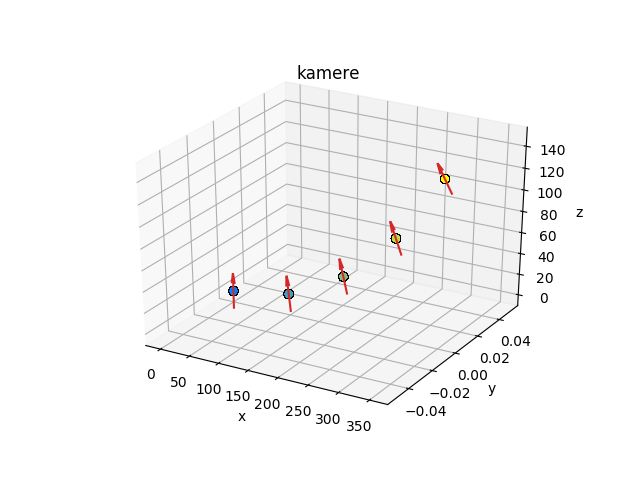

In [6]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.quiver(Xs, Ys, Zs, Xd, Yd, Zd, color='C3', length=35, normalize=True, pivot='middle')
ax.scatter(Xs, Ys, Zs, c=c_colors, antialiased=False, depthshade=False, edgecolor='k', linewidth=0.01, s=50)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_title('kamere')
plt.show()

### Točke

In [7]:
N_points = 10
rand_amp = r / 5
r_t = r//4

phi = np.linspace(np.pi/3, 2*np.pi/3, int(N_points**(1/2)))
theta = np.linspace(np.pi/4, 5*np.pi/4, int(N_points**(1/2)))

kx, ky = np.meshgrid(theta, phi)
XX = r_t * np.cos(kx) * np.sin(ky)
ZZ = r_t * np.sin(kx) * np.sin(ky)  + r
YY = r_t * np.cos(ky)

In [8]:
XX = XX + np.random.randn(*XX.shape) * rand_amp
YY = YY + np.random.randn(*YY.shape) * rand_amp
ZZ = ZZ + np.random.randn(*ZZ.shape) * rand_amp

<IPython.core.display.Javascript object>


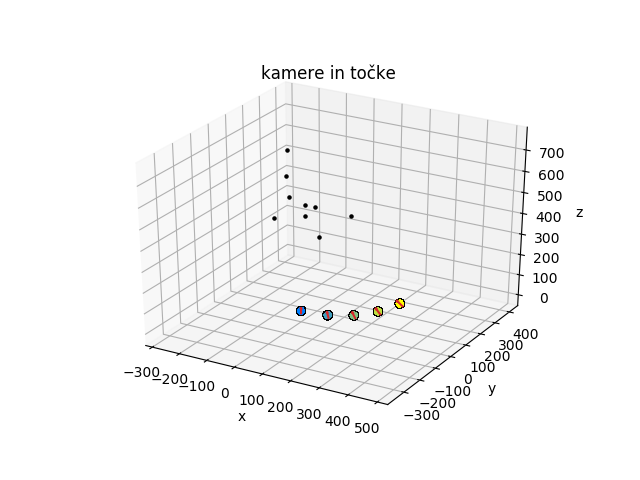

In [9]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.quiver(Xs, Ys, Zs, Xd, Yd, Zd, color='C3', length=35, normalize=True, pivot='middle')
ax.scatter(Xs, Ys, Zs, c=c_colors, antialiased=False, depthshade=False, edgecolor='k', linewidth=0.01, s=50)

ax.scatter(XX, YY, ZZ, c='k', marker='.', depthshade=False)

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_title('kamere in točke')

#bounding box (equal spect ratio)
X_max = np.max([Xs.max(), XX.max()])
Y_min = np.min([Xs.min(), XX.min()])
Y_max = np.max([Ys.max(), YY.max()])
X_min = np.min([Ys.min(), YY.min()])
Z_max = np.max([Zs.max(), ZZ.max()])
Z_min = np.min([Zs.min(), ZZ.min()])

max_range = np.array([X_max-X_min, Y_max-Y_min, Z_max-Z_min]).max()
Xb = 0.5*max_range*np.mgrid[-1:2:2,-1:2:2,-1:2:2][0].flatten() + 0.5*(X_max+X_min)
Yb = 0.5*max_range*np.mgrid[-1:2:2,-1:2:2,-1:2:2][1].flatten() + 0.5*(Y_max+Y_min)
Zb = 0.5*max_range*np.mgrid[-1:2:2,-1:2:2,-1:2:2][2].flatten() + 0.5*(Z_max+Z_min)
for xb, yb, zb in zip(Xb, Yb, Zb):
    ax.plot([xb], [yb], [zb], 'w')

plt.show()

In [10]:
XYZ = np.column_stack((XX.ravel(), YY.ravel(), ZZ.ravel(), np.ones_like(XX.ravel())))

In [11]:
xyz = [(np.dot(Ps[i], XYZ.T).T[:, :2]).astype(np.float64) for i in range(N_cams)]

<IPython.core.display.Javascript object>


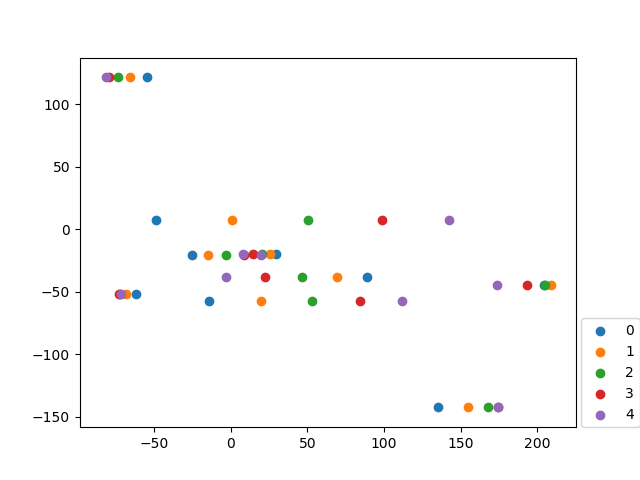

In [12]:
plt.figure()
for i in range(N_cams):
    plt.scatter(xyz[i][:, 0], xyz[i][:,1], c='C{:d}'.format(i), label='{:d}'.format(i))
plt.legend(loc=(1.01, 0))

### Naključne točke iz prvih nekaj kamer:

pikazane točke [2 0 0 5 3]


<IPython.core.display.Javascript object>


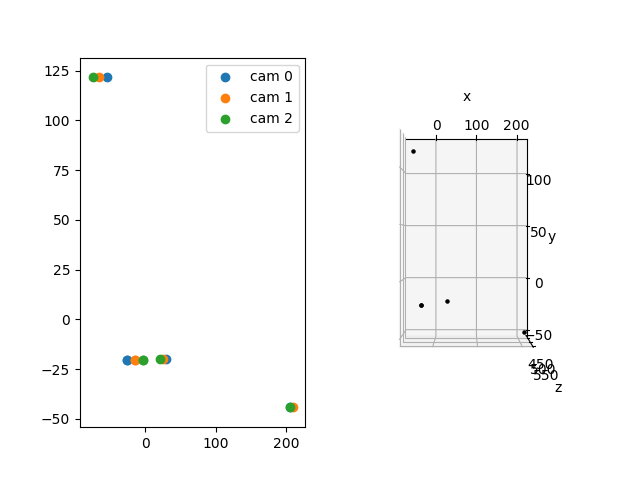

In [13]:
ncams = 3
npoints = 5
pointind = np.random.choice(np.arange(N_points-1), npoints)
print('pikazane točke {}'.format(pointind))

fig = plt.figure()
for i in range(ncams):
    cam = i
    ax_p = fig.add_subplot(1, 2, 1)
    ax_p.scatter(xyz[cam][pointind, 0], xyz[i][pointind, 1], c='C{:d}'.format(i), label='cam {:d}'.format(cam))
ax_p.legend()
    
ax_3d = fig.add_subplot(1, 2, 2, projection='3d')
ax_3d.scatter(XYZ[pointind, 0], XYZ[pointind, 1], XYZ[pointind, 2], c='k', marker='.', depthshade=False)
ax_3d.set_xlabel('x')
ax_3d.set_ylabel('y')
ax_3d.set_zlabel('z')
ax_3d.view_init(90, 270)

plt.show()

In [37]:
def get_camera_matrices(p1, p2, K, P1=None, d_max=1, alpha=0.995):
    """
    Camera matrix estimation from known point correspondances.
    P = [R|t] ... normalized camera matrix; P1 = [I|0] (H&Z, p. 257)
    """
    
    if P1 is None:
        P1 = np.column_stack((np.eye(3), np.zeros(3)))
    
    F, mask = cv2.findFundamentalMat(p1, p2, cv2.FM_8POINT, d_max, alpha)
    
    # essential matrix (H&Z, p. 257)
    E = K.T.dot(F).dot(K)
    U, D, VT = np.linalg.svd(E) # np.linalg.svd -> U, D, V.T

    W = np.array([[0, -1, 0],
                  [1, 0, 0],
                  [0, 0, 1]], dtype=float)
    
    u3 = U[:, -1]
    R1 = U.dot(W).dot(VT)
    R2 = U.dot(W.T).dot(VT)
    #positive determinants
    R1 = R1 * np.sign(np.linalg.det(R1))
    R2 = R2 * np.sign(np.linalg.det(R2)) 
    
    # four possibilities for the second camera matrix P2 (H&Z, p. 259)
    P1_4 = np.vstack((P1, np.array([0, 0, 0, 1])))
    P2_1 = np.column_stack((R1, u3)).dot(P1_4)
    P2_2 = np.column_stack((R1, -u3)).dot(P1_4)
    P2_3 = np.column_stack((R2, u3)).dot(P1_4)
    P2_4 = np.column_stack((R2, -u3)).dot(P1_4)
    P2_list = [P2_1, P2_2, P2_3, P2_4]
    
    # test points to determine if projections are in front of both cameras
    tally = np.zeros(4)
    for x1, x2 in zip(p1, p2):
        for i, P2 in enumerate(P2_list):
            X = tools.triangulate_lsq(tools.to_homogenous(x1), tools.to_homogenous(x2), P1, P2)
            if tools.in_front(X, P2) and tools.in_front(X, P1):
                tally[i] += 1
    P2 = P2_list[np.argmax(tally)]
    
    return P1, P2

In [38]:
def get_camera_matrices_PnP(p2, K, X, d_max=1, alpha=0.995, RANSAC=True):
    """
    PnP camera estimation using known point correspondances and 3D positions.
    P = [R|t] ... normalized camera matrix; P1 = [I|0] (H&Z, p. 257)
    """
    
    X = X.astype(np.float64)
    p2 = p2.astype(np.float64)
    if RANSAC:
        retval, rvec, tvec, mask = cv2.solvePnPRansac(X, p2, cameraMatrix=K, distCoeffs=np.zeros(8))
    else:
        retval, rvec, tvec= cv2.solvePnP(X, p2, cameraMatrix=K, distCoeffs=np.zeros(4))

    R2, jac = cv2.Rodrigues(rvec)
    R2 = R2 * np.sign(np.linalg.det(R2))
    P2 = np.column_stack((R2, tvec))

    return P2

In [39]:
K = np.eye(3)

#### F pose estimation

In [40]:
P_reconstructed = [np.column_stack((np.eye(3), np.zeros(3)))]
for i in range(N_cams - 1):
    p1, p2 = xyz[i].astype(np.float64), xyz[i+1].astype(np.float64)
    P1, P2 = get_camera_matrices(p1, p2, K)
    P_reconstructed.append(P2)

#### PnP Pose estimation

In [41]:
P_reconstructed_PnP = [np.column_stack((np.eye(3), np.zeros(3)))]
for i in range(N_cams - 1):
    p2 = xyz[i+1]
    P2 = get_camera_matrices_PnP(p2, K, XYZ[:, :-1], RANSAC=True)
    P_reconstructed_PnP.append(P2)

## Prikaz

In [42]:
izpis = True
P_za_prikaz = P_reconstructed_PnP
P_za_prikaz = P_reconstructed

In [43]:
if izpis:
    np.set_printoptions(precision=2)
    print('\nRECONSTRUCTED')
    for i, _ in enumerate(P_za_prikaz):
        print('P{:d} '.format(i) + '*' * 45)
        print(_)
        print()
    print('-' * 50)
    print('\nACTUAL')
    for i, _ in enumerate(Ps):
        print('P{:d} '.format(i) + '*' * 45)
        print(_)
        print()


RECONSTRUCTED
P0 *********************************************
[[ 1.  0.  0.  0.]
 [ 0.  1.  0.  0.]
 [ 0.  0.  1.  0.]]

P1 *********************************************
[[  1.00e+00   2.04e-15   4.64e-17   1.00e+00]
 [ -1.98e-15   1.00e+00   2.06e-14  -1.52e-15]
 [  1.24e-16  -2.08e-14   1.00e+00   2.20e-16]]

P2 *********************************************
[[  1.00e+00   6.08e-15  -7.35e-17  -1.00e+00]
 [ -6.10e-15   1.00e+00   1.43e-13   9.35e-15]
 [  1.12e-16  -1.43e-13   1.00e+00  -6.66e-16]]

P3 *********************************************
[[  1.00e+00   6.17e-15   1.72e-16  -1.00e+00]
 [ -6.19e-15   1.00e+00   5.56e-14  -7.35e-15]
 [  3.22e-17  -5.54e-14   1.00e+00   2.22e-16]]

P4 *********************************************
[[  1.00e+00   1.71e-14  -3.38e-16  -1.00e+00]
 [ -1.71e-14   1.00e+00   1.63e-13  -3.05e-14]
 [  4.56e-16  -1.63e-13   1.00e+00   3.33e-16]]

--------------------------------------------------

ACTUAL
P0 *********************************************
[

In [44]:
Xs_r, Ys_r, Zs_r = np.array([tools.pos_from_P(P)[:-1, -1] for P in P_za_prikaz]).T
Xd_r, Yd_r, Zd_r = np.array([Rt[2, :-1] for Rt in P_za_prikaz]).T

<IPython.core.display.Javascript object>


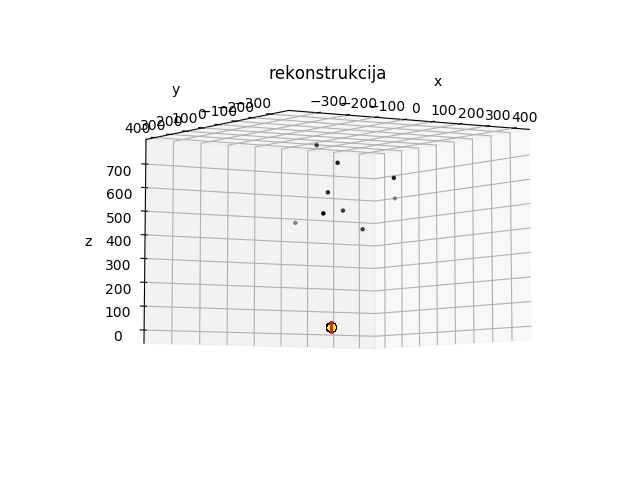

In [45]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.quiver(Xs_r, Ys_r, Zs_r, Xd_r, Yd_r, Zd_r, color='C3', length=50, normalize=True, pivot='middle')
ax.scatter(Xs_r, Ys_r, Zs_r, c=c_colors, antialiased=False, depthshade=False, edgecolor='k', linewidth=0.01, s=50)
ax.scatter(XX, YY, ZZ, c='k', marker='.')

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_title('rekonstrukcija')

#bounding box (equal spect ratio)
X_max = np.max([Xs_r.max(), XX.max()])
Y_min = np.min([Xs_r.min(), XX.min()])
Y_max = np.max([Ys_r.max(), YY.max()])
X_min = np.min([Ys_r.min(), YY.min()])
Z_max = np.max([Zs_r.max(), ZZ.max()])
Z_min = np.min([Zs_r.min(), ZZ.min()])

max_range = np.array([X_max-X_min, Y_max-Y_min, Z_max-Z_min]).max()
Xb = 0.5*max_range*np.mgrid[-1:2:2,-1:2:2,-1:2:2][0].flatten() + 0.5*(X_max+X_min)
Yb = 0.5*max_range*np.mgrid[-1:2:2,-1:2:2,-1:2:2][1].flatten() + 0.5*(Y_max+Y_min)
Zb = 0.5*max_range*np.mgrid[-1:2:2,-1:2:2,-1:2:2][2].flatten() + 0.5*(Z_max+Z_min)
for xb, yb, zb in zip(Xb, Yb, Zb):
    ax.plot([xb], [yb], [zb], 'w')

plt.show()


plt.show()

In [46]:
xyz_r = [(np.dot(P_za_prikaz[i], XYZ.T).T[:, :2]).astype(np.float64) for i in range(N_cams)]

<IPython.core.display.Javascript object>


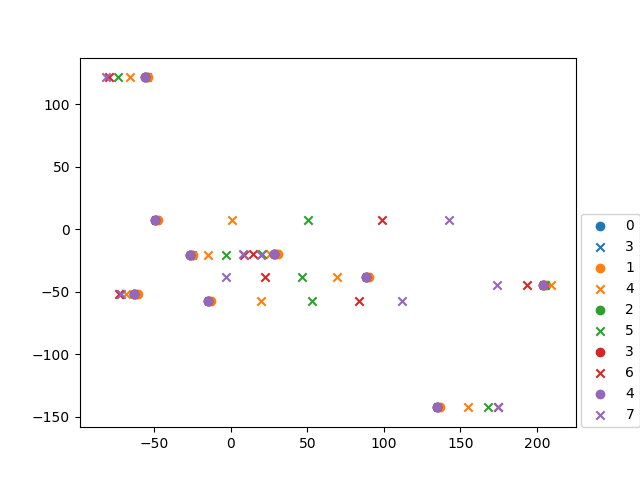

In [47]:
plt.figure()
for i in range(N_cams):
    plt.scatter(xyz_r[i][:, 0], xyz[i][:,1], c='C{:d}'.format(i), label='{:d}'.format(i))
    plt.scatter(xyz[i][:, 0], xyz[i][:,1], c='C{:d}'.format(i), label='{:d}'.format(i+3), marker='x')
plt.legend(loc=(1.01, 0))

-----------

In [25]:
#test_cloud = pickle.load(open('results\scene_dinoRing_cameradirtest_28-08-15-40.pkl', 'rb'))
#test_cloud = pickle.load(open('results\kip\scene__outliers_removed_kip_pairwise_X_only_PnP_sequential_final_BA_10-08-13-50_25-08-13-03.pkl', 'rb'))
#XYZ = test_cloud.render(cameras=True, q_length=1)